In [1]:
import torch 
import torch.nn as nn
import numpy as np 
import matplotlib.pyplot as plt

# CUDA support 
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
    
torch.manual_seed(0)
np.random.seed(0)

In [2]:
def oscillator_numpy(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = np.cos(phi+w*x)
    sin = np.sin(phi+w*x)
    exp = np.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [3]:
d, w0 = 1, 20

In [4]:
def oscillator_torch(d, w0, x):
    
    """
    @author: bmoseley
    Defines the analytical solution to the 1D underdamped harmonic oscillator problem. 
    Equations taken from: https://beltoforion.de/en/harmonic_oscillator/
    """
    assert d < w0
    w = np.sqrt(w0**2-d**2)
    phi = np.arctan(-d/w)
    A = 1/(2*np.cos(phi))
    cos = torch.cos(phi+w*x)
    sin = torch.sin(phi+w*x)
    exp = torch.exp(-d*x)
    y  = exp*2*A*cos
    return y

In [5]:
class LSTM(nn.Module):
    
    def __init__(self, hidden_layers=64,outputs=1 ):
        super(LSTM, self).__init__()
        self.hidden_layers = hidden_layers
        # lstm1, lstm2, linear are all layers in the network
        
        self.lstm1 = nn.LSTMCell(1, self.hidden_layers).to(device)
        self.lstm2 = nn.LSTMCell(self.hidden_layers, self.hidden_layers).to(device)
        self.linear = nn.Linear(self.hidden_layers, outputs).to(device)
        self.optimizer = torch.optim.LBFGS(self.parameters(), lr=1.0)
        self.optimizer_Adam = torch.optim.Adam(self.parameters(), lr=1e-3)
        
        
    def forward(self, y, future_preds=0):
        outputs, num_samples = [], y.size(0)
        h_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        h_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        c_t2 = torch.zeros(num_samples, self.hidden_layers, dtype=torch.float32).to(device)
        
        for time_step in y.split(1, dim=1):
            # N, 1
            h_t, c_t = self.lstm1(time_step, (h_t, c_t)) # initial hidden and cell states
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2)) # new hidden and cell states
            output = self.linear(h_t2)# output from the last FC layer
            outputs.append(output)
            
        for i in range(future_preds):
            # this only generates future predictions if we pass in future_preds>0
            # mirrors the code above, using last output/prediction as input
            h_t, c_t = self.lstm1(output, (h_t, c_t))
            h_t2, c_t2 = self.lstm2(h_t, (h_t2, c_t2))
            output = self.linear(h_t2)
            outputs.append(output)
            
        # transform list to tensor    
        outputs = torch.cat(outputs, dim=1).to(device)
        return outputs
    


2 min 

In [6]:
class PhysicsInformedNN():
    
    def __init__(self):
        # deep neural networks
        self.dnn = LSTM().to(device)
        
        
    def net_u(self,t,future_preds=0):  
        u = self.dnn.forward(t, future_preds)
        return u
    
    def derivates(self, u ,coordinates):
        
        coordinates = (coordinates.to(device),)
        u_t = torch.gradient(u, spacing = coordinates)[0].to(device) 
        u_tt = torch.gradient(u, spacing = coordinates)[0].to(device) 

        return u_t , u_tt
    
    def net_f(self,t,lambda1=1.0,lambda2=400.0):
        """ The pytorch autograd version of calculating residual """

        u = self.net_u(t)
        
        u_t = torch.zeros(len(u),len(u[0])).to(device)
        u_tt = torch.zeros(len(u),len(u[0])).to(device)
        
        coordinate_t = torch.linspace(0,1,len(u[0]))
        for i , time_serie in enumerate(u): 
            u_t[i], u_tt[i] =  self.derivates(time_serie, coordinate_t)
            
        f = u_tt + lambda1*u_t + lambda2*u
        return f.to(device), u , u_t , u_tt
    
    def predict(self, t,future_preds=0):
        self.dnn.eval()
        u = self.net_u(t,future_preds=0)
        return u 

(1e-9) y (1e-8) physics[,1:]
ok

muy buenos resultados con noise 0.1 y 29 iteraciones 


buenos resultados con noise 0.3 y 10 rep 
     :loss_pde + (1e-10)*(loss_u_pred + loss_u_t)
     
     
excelentes resultados: 

17 iter 

noise=0.5

loss_pde = (1e-8)*torch.mean(physics** 2)  

loss = loss_u + loss_pde + (1e-10)*(loss_u_pred + loss_u_t)




In [7]:

n_mitad=70
x = torch.linspace(0,2,n_mitad).requires_grad_()
x = x.repeat(4,1)
y = oscillator_torch(d, w0, x)
noise = 0.5
y_with_noise = y + noise*torch.std(y)*torch.randn(size=x.size())

In [8]:
# load data and make training set
inpu = y_with_noise[3:, :-1].to(device)
target = y_with_noise[3:, 1:].to(device)
test_input = y_with_noise[:3, :-1].to(device)
test_target = y_with_noise[:3, 1:].to(device)


STEP:  0
loss: 0.1295720338821411
loss: 0.12602432072162628
loss: 0.1259589046239853
loss: 0.12587621808052063
loss: 0.12558665871620178
loss: 0.12501251697540283
loss: 0.12388432025909424
loss: 0.12159251421689987
loss: 0.13170941174030304
loss: 0.12090149521827698
loss: 0.12052766233682632
loss: 0.12017502635717392
loss: 0.1197347640991211
loss: 0.11940453946590424
loss: 0.11905516684055328
loss: 0.11867998540401459
loss: 0.11827603727579117
loss: 0.11784059554338455
loss: 0.11737078428268433
loss: 0.1168634220957756
Loss u: 1.245610e-01


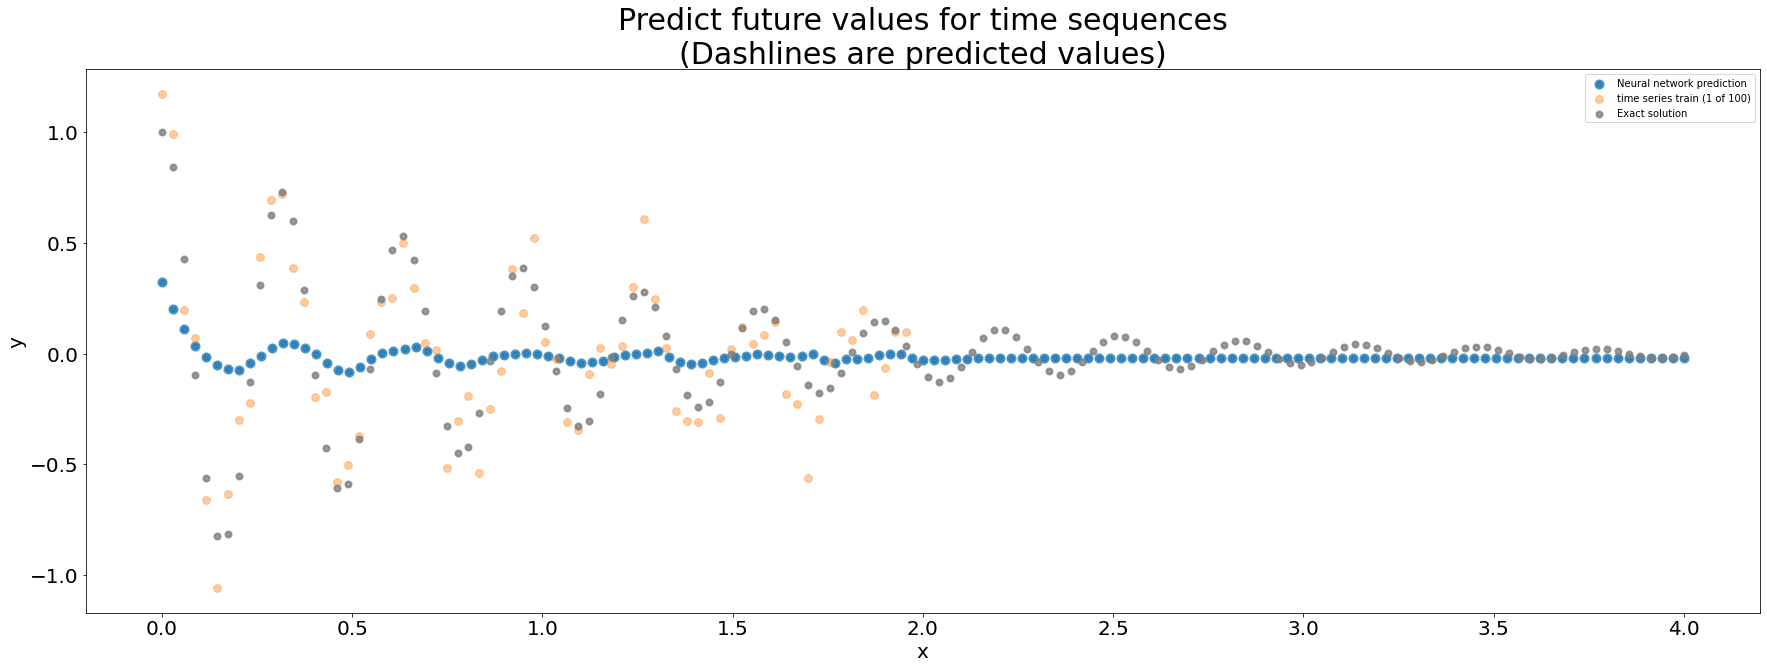

STEP:  1
loss: 0.11631511896848679
loss: 0.11572212725877762
loss: 0.11508042365312576
loss: 0.11438558250665665
loss: 0.11363294720649719
loss: 0.11281748861074448
loss: 0.11193390935659409
loss: 0.11097666621208191
loss: 0.10994012653827667
loss: 0.10881856083869934
loss: 0.10760641098022461
loss: 0.10629844665527344
loss: 0.10488999634981155
loss: 0.1033773124217987
loss: 0.10175792872905731
loss: 0.10003097355365753
loss: 0.09819765388965607
loss: 0.09626154601573944
loss: 0.09422892332077026
loss: 0.09210896492004395
Loss u: 9.062253e-02


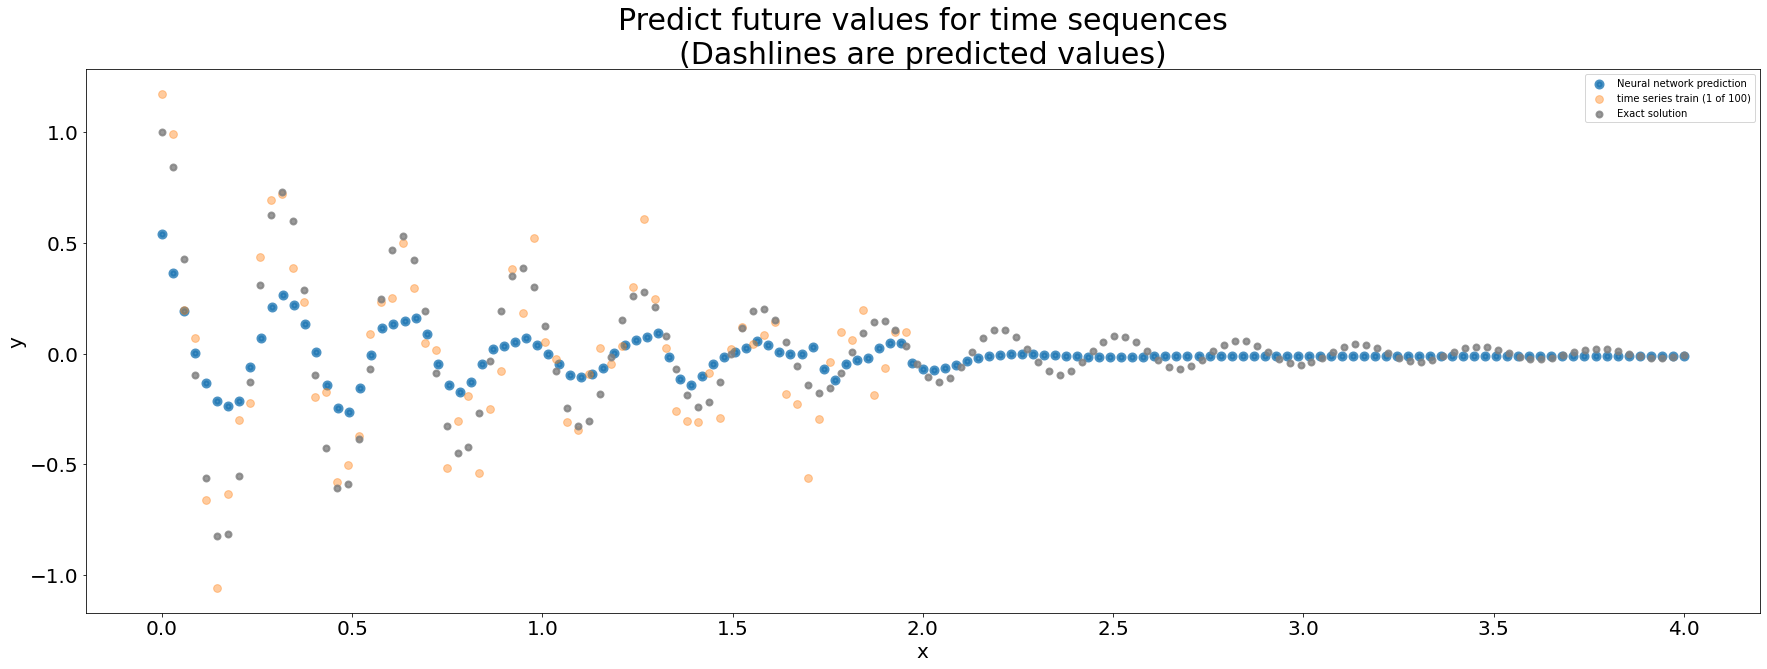

STEP:  2
loss: 0.08991360664367676
loss: 0.08765754848718643
loss: 0.08535764366388321
loss: 0.08303254842758179
loss: 0.0807017907500267
loss: 2801.513427734375
loss: 0.04682713374495506
loss: 0.043920744210481644
loss: 0.04050985723733902
loss: 0.03889188915491104
loss: 0.03786282613873482
loss: 0.036111120134592056
loss: 0.03571248799562454
loss: 0.0352553129196167
loss: 0.035189591348171234
loss: 0.035156406462192535
loss: 0.03513115644454956
loss: 0.03496727719902992
loss: 0.03441284969449043
loss: 0.03418053686618805
Loss u: 3.980551e-02


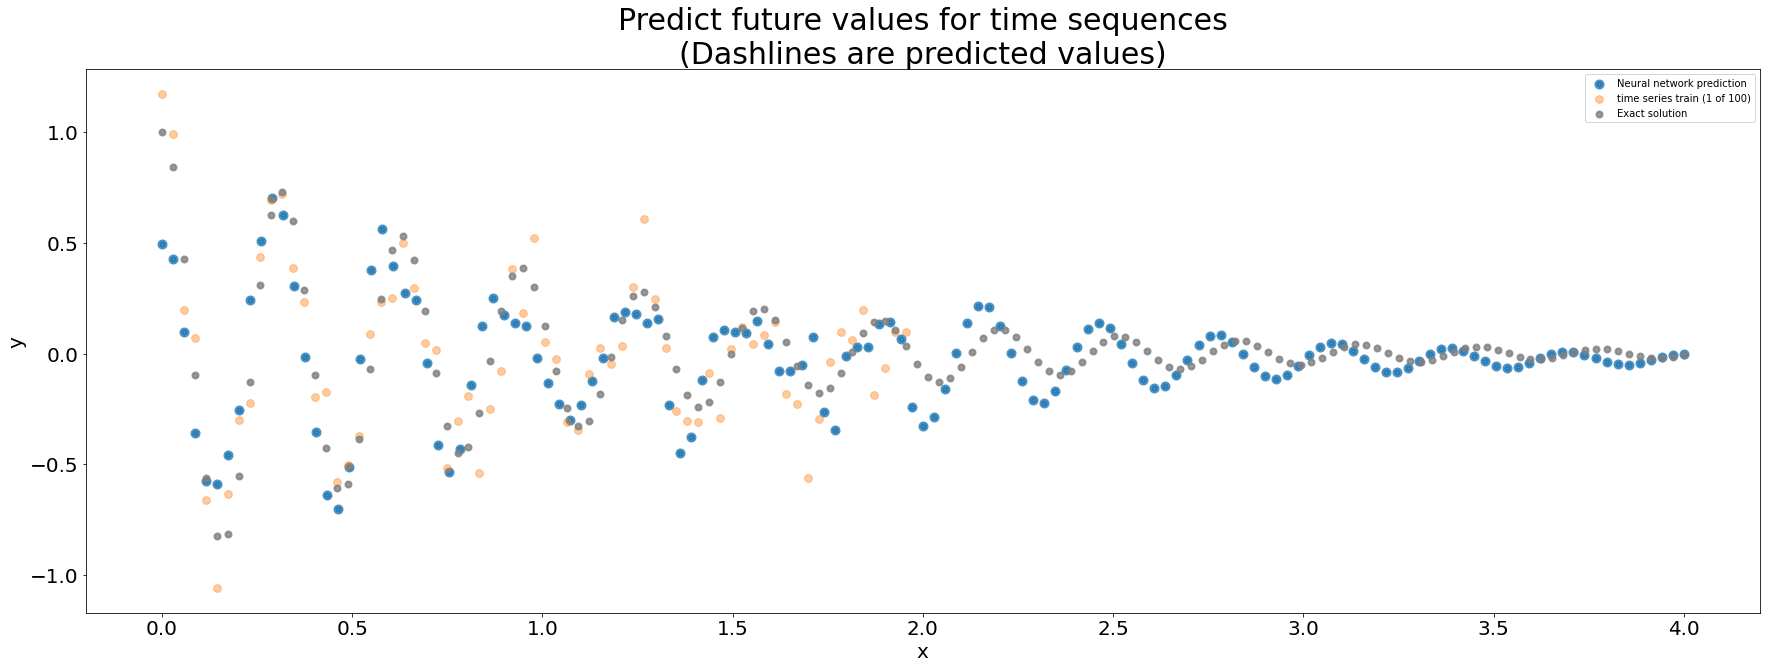

STEP:  3
loss: 0.033850088715553284
loss: 0.033858850598335266
loss: 0.03350844979286194
loss: 0.03347992151975632
loss: 0.03346974775195122
loss: 0.03343823552131653
loss: 0.03274278715252876
loss: 0.03234247490763664
loss: 0.03203994408249855
loss: 0.03242349997162819
loss: 0.031823351979255676
loss: 0.03195786103606224
loss: 0.03174165263772011
loss: 0.031730543822050095
loss: 0.03172162547707558
loss: 0.031712856143713
loss: 0.03164807707071304
loss: 0.03148222714662552
loss: 0.03128715977072716
loss: 0.030982017517089844
Loss u: 3.776991e-02


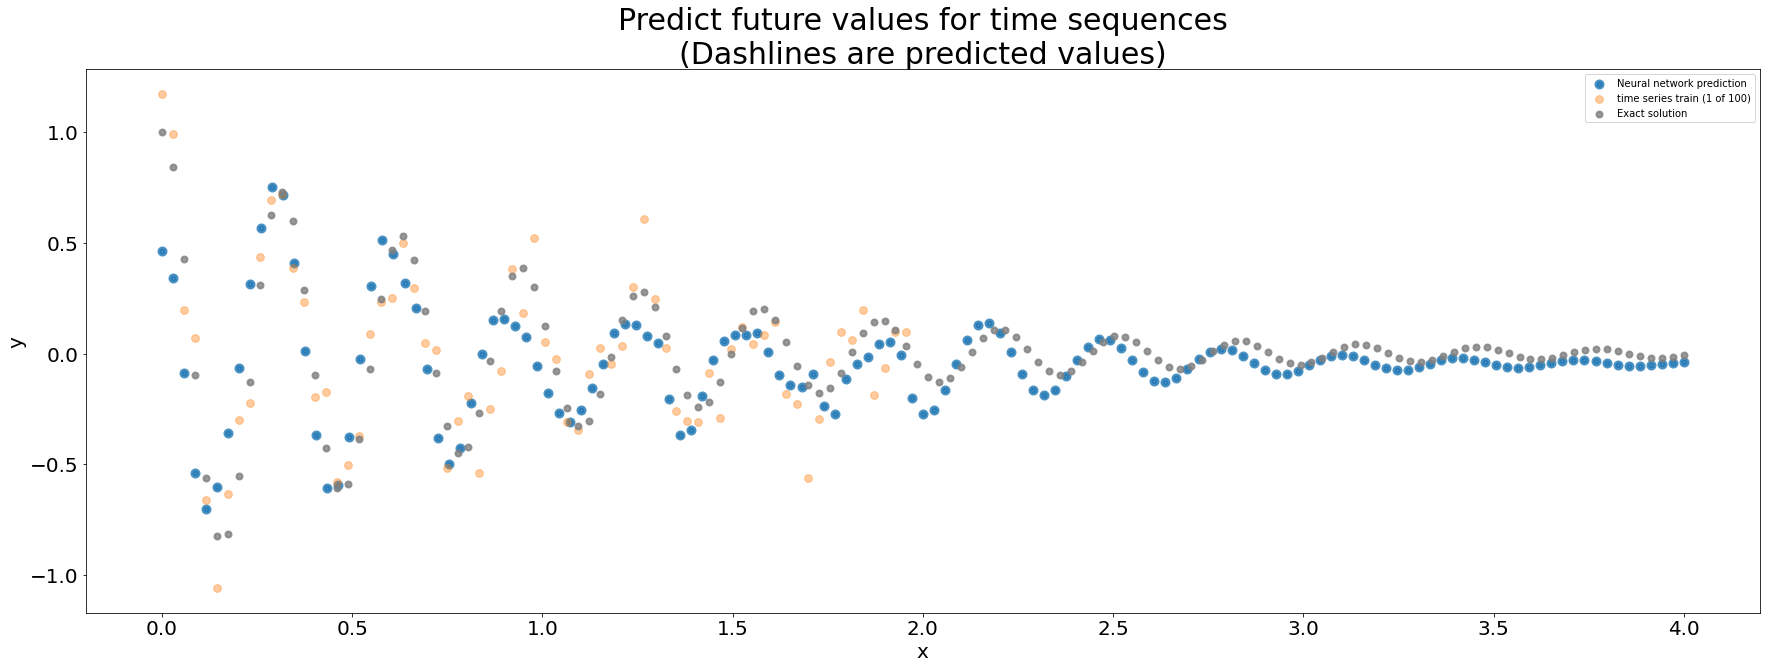

STEP:  4
loss: 0.030862610787153244
loss: 0.030846472829580307
loss: 0.030797310173511505
loss: 0.03078797645866871
loss: 0.030783163383603096
loss: 0.030771924182772636
loss: 0.030643699690699577
loss: 0.030514655634760857
loss: 0.030187906697392464
loss: 0.030095599591732025
loss: 0.030067605897784233
loss: 0.03003571555018425
loss: 0.030025897547602654
loss: 0.030015207827091217
loss: 0.029969271272420883
loss: 0.029896670952439308
loss: 0.029772968962788582
loss: 0.02947956882417202
loss: 0.028945526108145714
loss: 0.06308447569608688
Loss u: 4.949040e-02


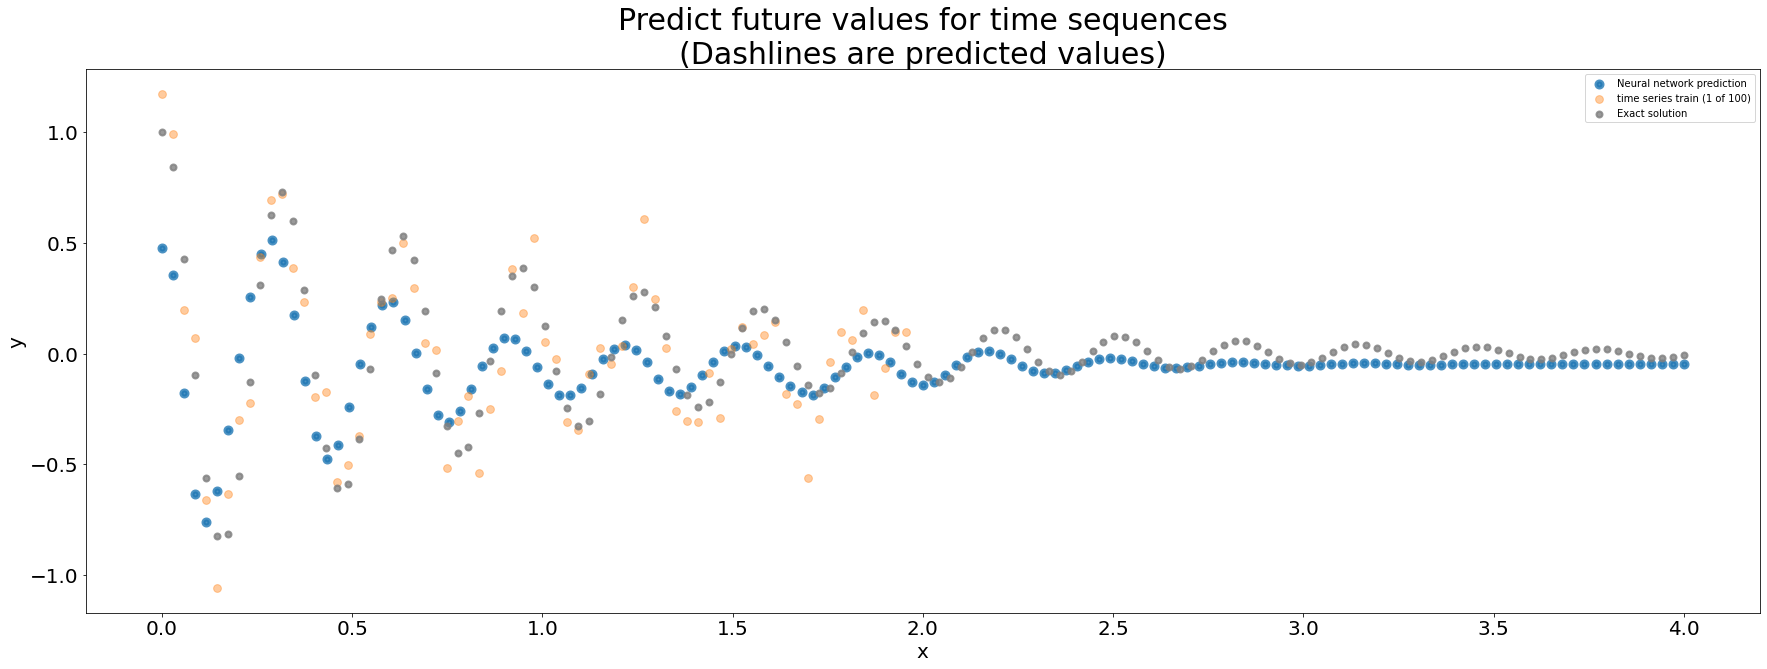

STEP:  5
loss: 0.03970460966229439
loss: 0.5666221380233765
loss: 1128.311767578125
loss: 80240107520.0
loss: 3496463826944.0
loss: 1.2816276900544512e+17
loss: 99972569628672.0
loss: 9.670193083978875e+17
loss: 120544473120768.0
loss: 345808754966528.0
loss: 580172906496000.0
loss: 1955577261457408.0
loss: 1304099710566400.0
loss: 373687723229184.0
loss: 825035837145088.0
loss: 6646220835520512.0
loss: 1224628051640320.0
loss: 4.754754911238252e+19
loss: 1.0854749230333952e+16
loss: 1.7343000631836672e+17
Loss u: 1.301569e+16


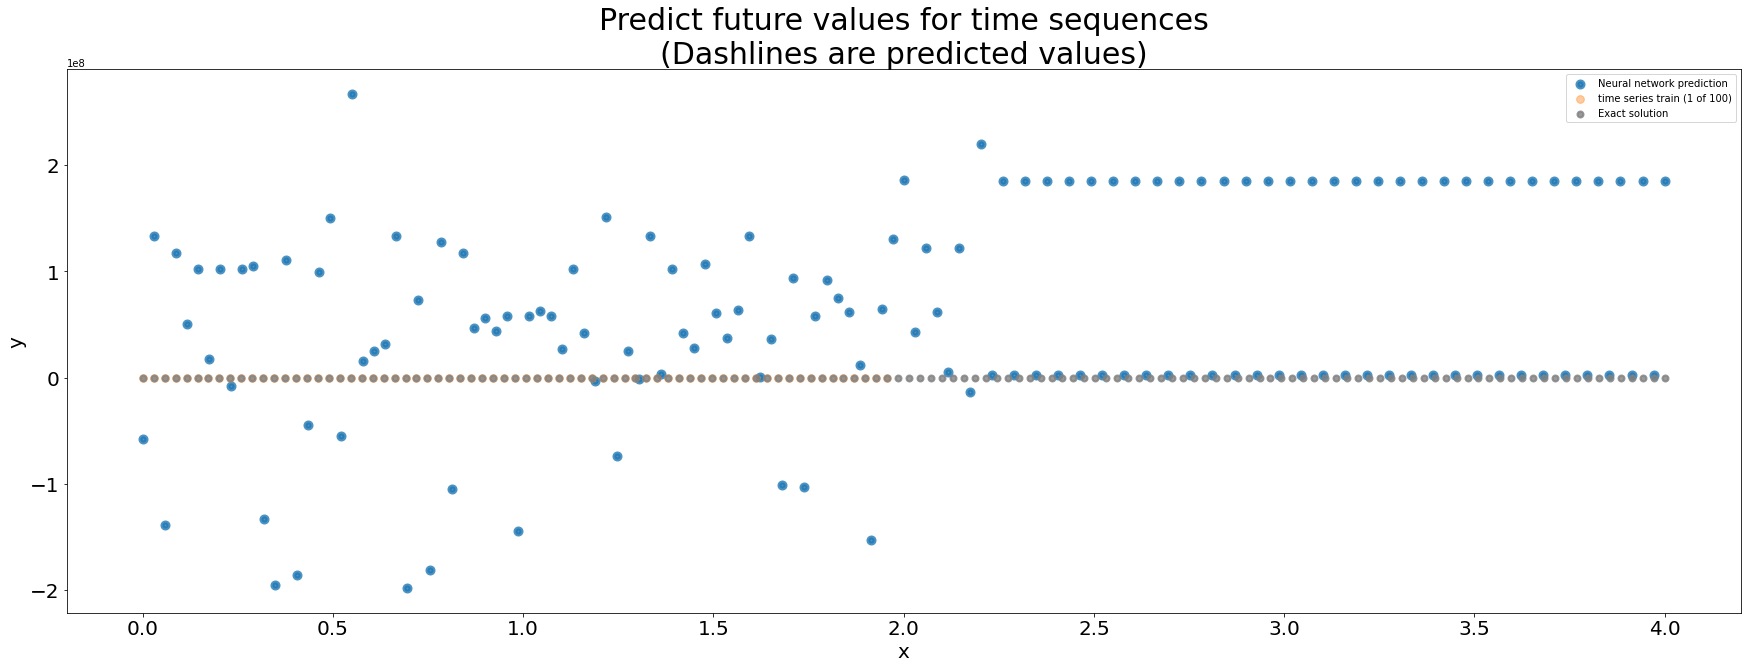

STEP:  6
loss: 2.212550255050752e+16
loss: 1.1997000721917542e+17
loss: 1.5781034602408302e+26
loss: 8.217322986248602e+16
loss: 3.0430547666796544e+17
loss: 2.5161457736246886e+17
loss: 3.1070287649740685e+19
loss: 2.5312901719077683e+18
loss: 1.016056056399895e+19
loss: 1.9873018462632673e+18
loss: 2.889972855120855e+19
loss: 6.671070747496022e+18
loss: 9.916801035144266e+18
loss: 4.209052600897676e+20
loss: 2.35488425146948e+18
loss: 2.7976166271667405e+18
loss: 1.7339093585986847e+18
loss: 1.6650044217388696e+19
loss: 8.130480293711708e+17
loss: 4.010694886830375e+18
Loss u: 4.226846e+17


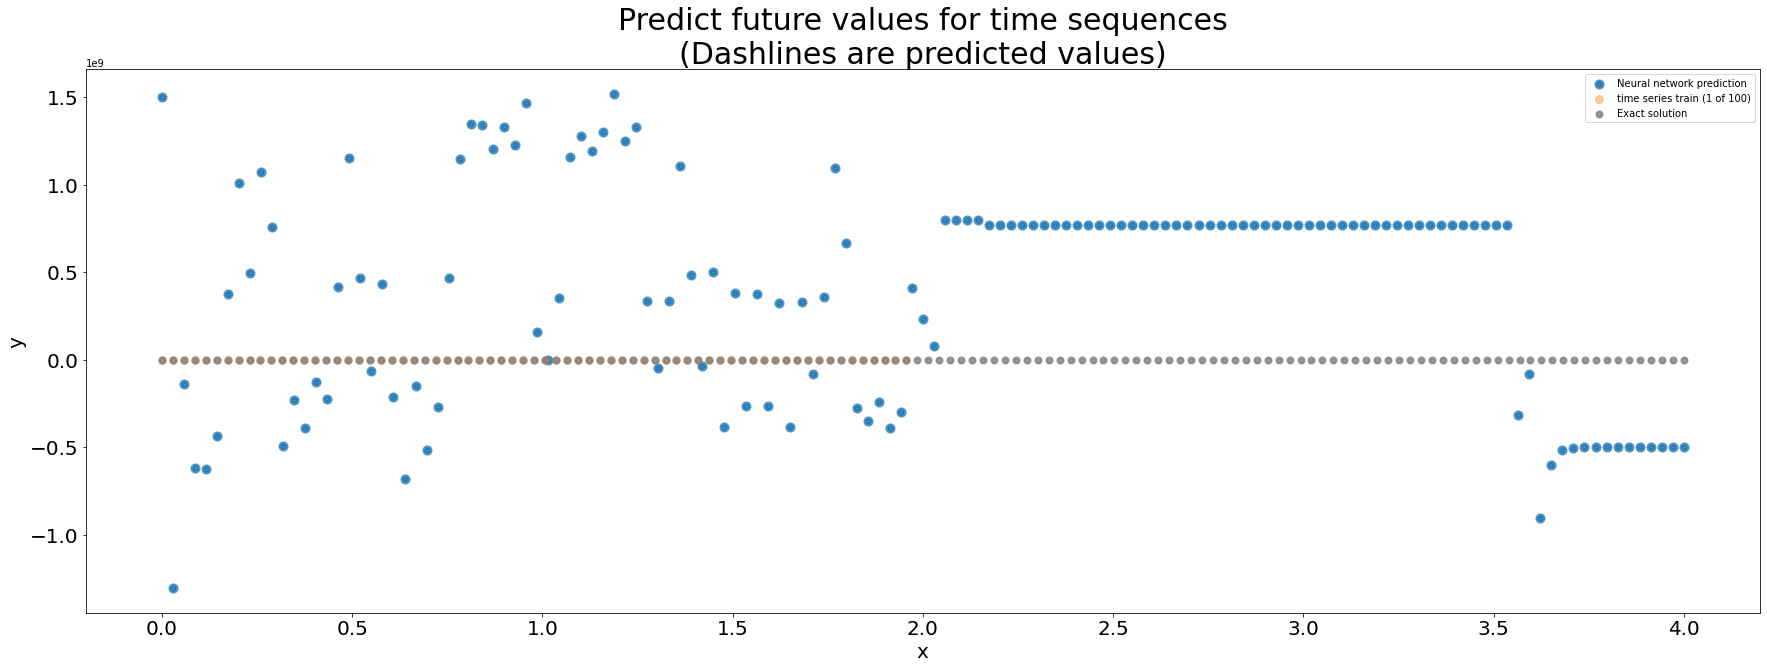

STEP:  7
loss: 2.89844899025938e+18
loss: 9.753252253925376e+17
loss: 6.420034650688717e+17
loss: 8.170934075276657e+17
loss: 5.2875445460271104e+17
loss: 7.156294437243453e+17
loss: 6.485709033490028e+22
loss: 4.897947375412183e+17
loss: 7.396040198900941e+17
loss: 3.9532861549287834e+17
loss: 2.3452956854415524e+18
loss: 1.2926268264216003e+18
loss: 1.205916178359255e+18
loss: 2.4411018716459827e+17
loss: 7.91858447439102e+17
loss: 6.619839278077706e+17
loss: 2.341666197558264e+18
loss: 1.3756226370105508e+18
loss: 1.54179072980471e+18
loss: 2.882939279237972e+18
Loss u: 5.724432e+17


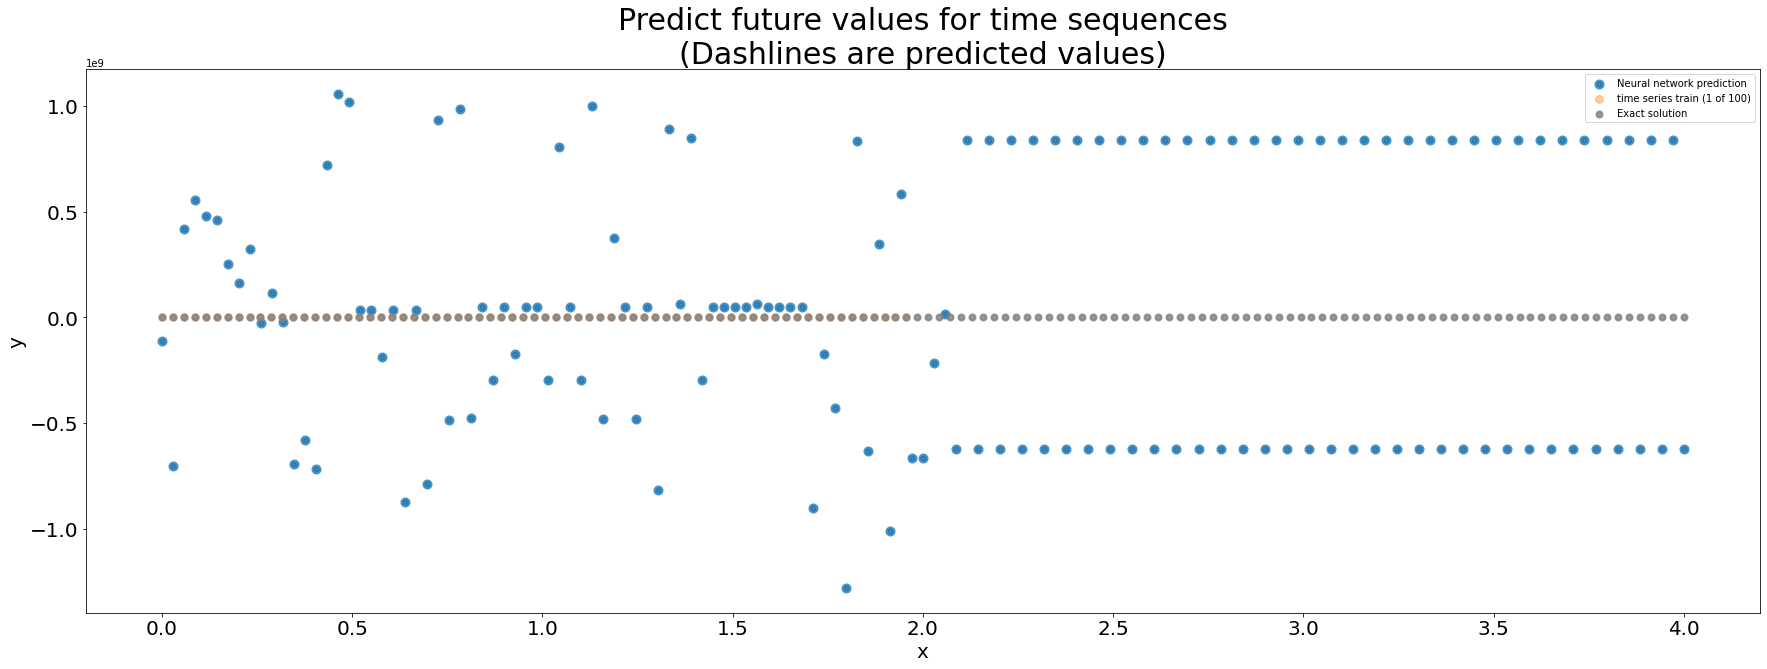

STEP:  8
loss: 9.927509041448223e+17
loss: 1.9790861579415716e+18
loss: 5.691989727821955e+18
loss: 5.23414126626603e+17
loss: 6.56835602049663e+17
loss: 1.756067301037179e+17
loss: 3.3056360791759913e+18
loss: 2.834845541127422e+18
loss: 2.317617129479733e+18
loss: 4.845781389829734e+18
loss: 1.583684871602045e+18
loss: 1.3387833624829624e+18
loss: 2.586936111792128e+17
loss: 2.154168678696878e+17
loss: 6.167129109236285e+17
loss: 3.133186888769208e+17
loss: 3.511197955606446e+17
loss: 2.3015623905444364e+19
loss: 6.034759729002054e+18
loss: 1.3665152722465194e+19
Loss u: 2.119818e+17


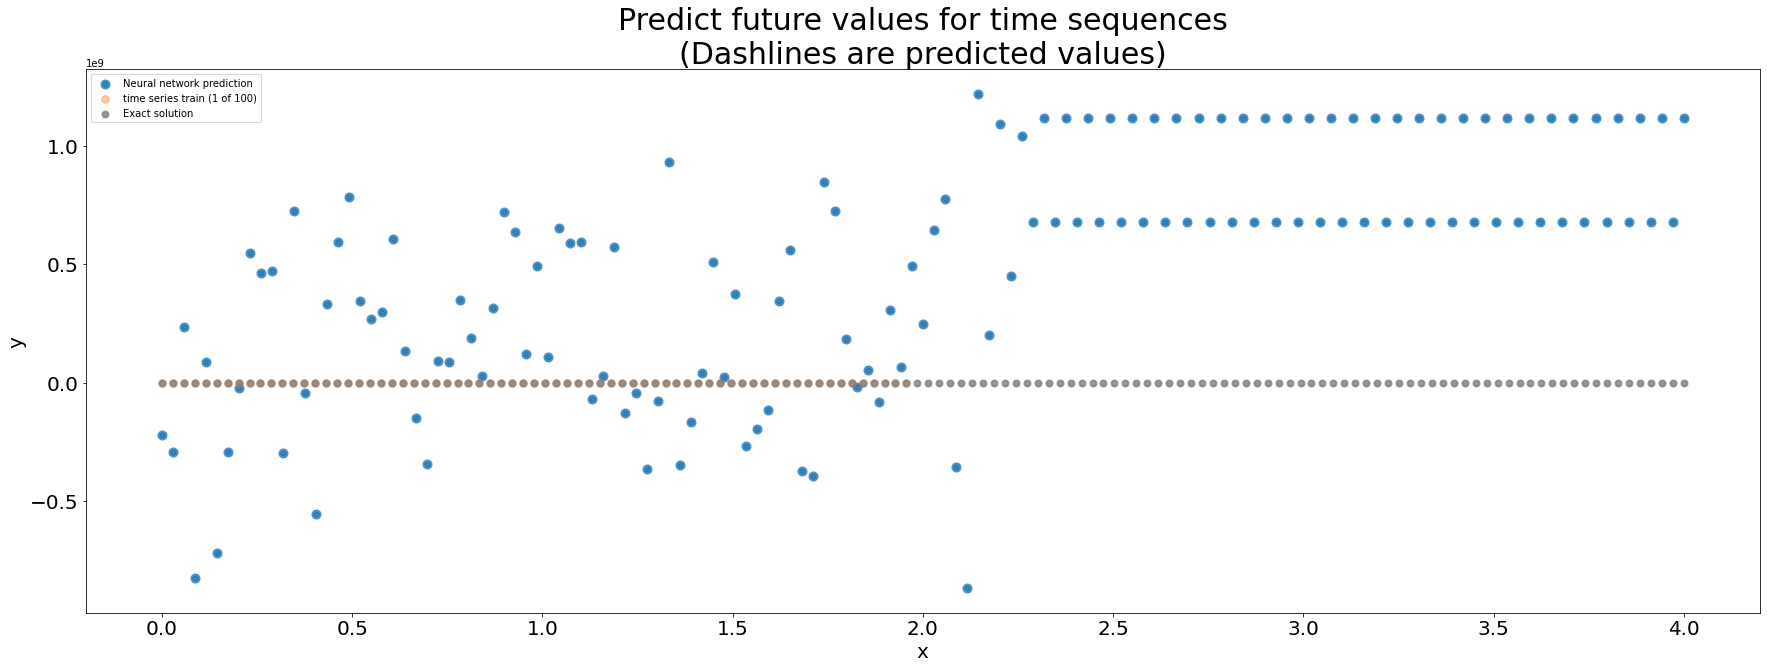

STEP:  9
loss: 2.8075881668385178e+17
loss: 8.697851658266214e+17
loss: 2.3902866017385185e+18
loss: 7.177670729993814e+18
loss: 6.863679895914938e+18
loss: 6.071728058706952e+18
loss: 1.1179752867365913e+19
loss: 3.5924755731185664e+18
loss: 2.848920526913536e+17
loss: 1.3619618750503322e+17
loss: 1.7223222927483208e+18
loss: 6.566321923985244e+17
loss: 3.5819417019686584e+18
loss: 3.127970723143667e+19
loss: 1.367789853613228e+18
loss: 3.0293860332601344e+16
loss: 7.380803029324268e+17
loss: 2.4222952406489498e+17
loss: 1.3206723443891896e+18
loss: 2.6016920732329574e+17
Loss u: 5.733915e+16


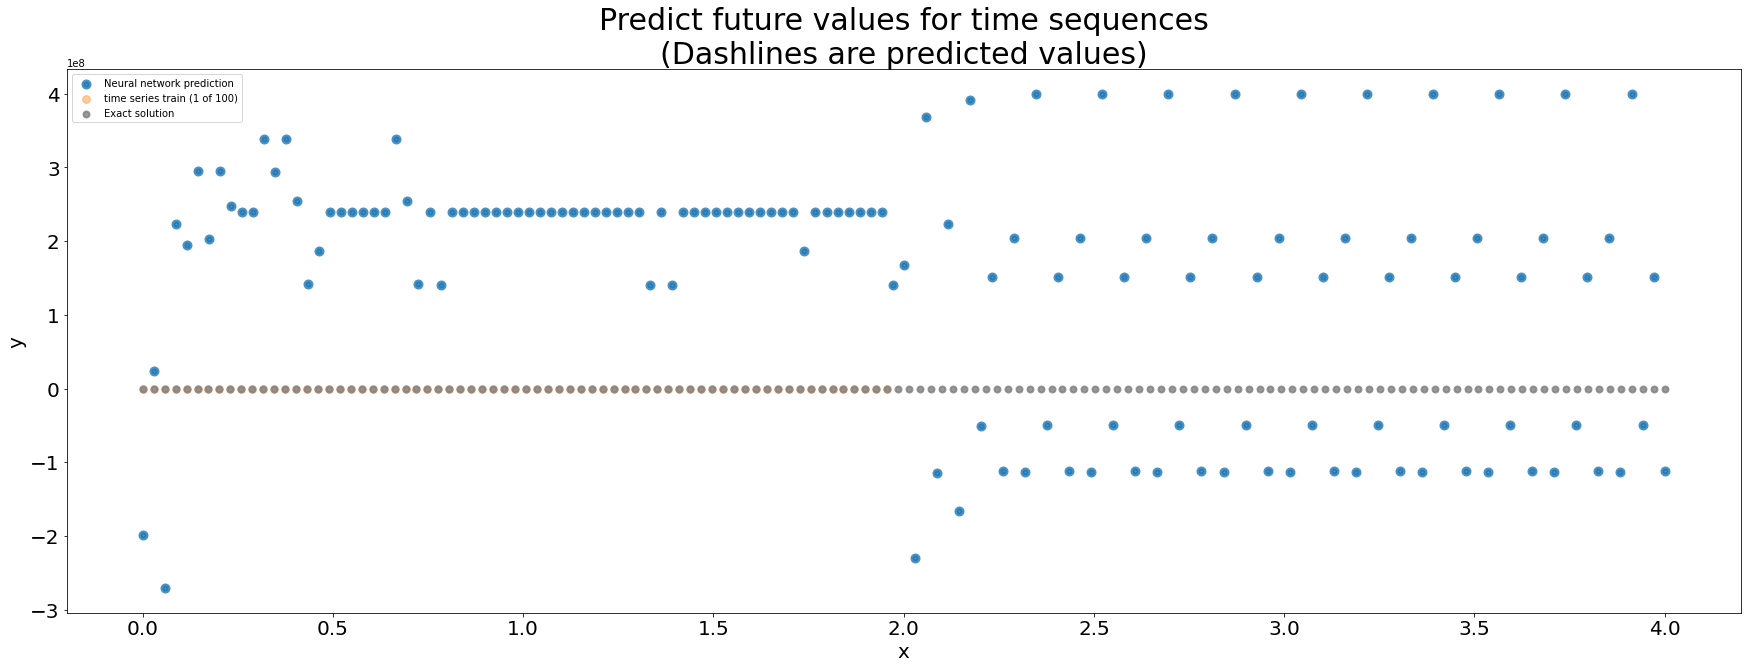

STEP:  10
loss: 6.971002074850918e+16
loss: 6.349198614069248e+17
loss: 1.3629640970789192e+18
loss: 9.945034569600205e+17
loss: 1.3274457483331502e+18
loss: 1.5958909624988467e+18
loss: 1.1416923985108009e+18
loss: 3.3942930002584535e+18
loss: 1.6752671808091587e+18
loss: 9.137564225277788e+17
loss: 2.433209886419452e+18
loss: 9.840254135130128e+18
loss: 2.1964719487709086e+19
loss: 2.7519601764814815e+19
loss: 1.1747680309926167e+19
loss: 1.2269540964061676e+18
loss: 3.342687971764601e+18
loss: 3.182801388899926e+18
loss: 6.548236497024608e+19
loss: 1.3581770983294894e+18
Loss u: 1.593094e+18


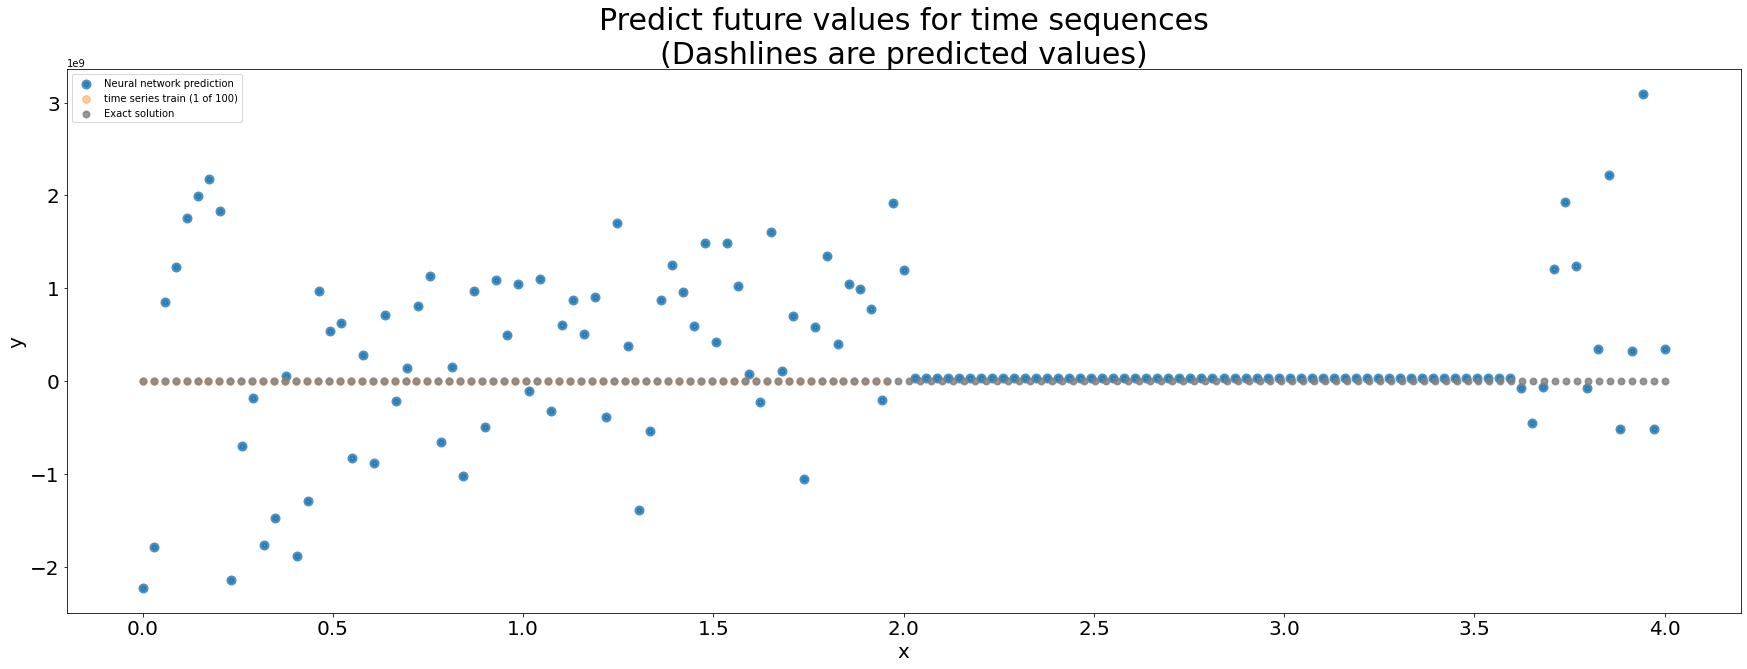

STEP:  11
loss: 1.7818534256889037e+18
loss: 6.66189092491572e+18
loss: 2.30290643355823e+19
loss: 1.6951302706817925e+18
loss: 3.561500956174582e+18
loss: 7.521472073080766e+18
loss: 4.2363561794139587e+18
loss: 3.729219910119719e+18
loss: 1.51562111611306e+17
loss: 3.327280240446669e+17
loss: 2.966965813258486e+17
loss: 4.7669704854228435e+20
loss: 1.1529587780510286e+19
loss: 9.045420741828532e+20
loss: 1.633097935704996e+20
loss: 1.3420179702209353e+22
loss: 4.90019786955581e+21
loss: 6.183998201458695e+20
loss: 1.8952667196849285e+22
loss: 8.00205633503189e+20
Loss u: 4.498809e+20


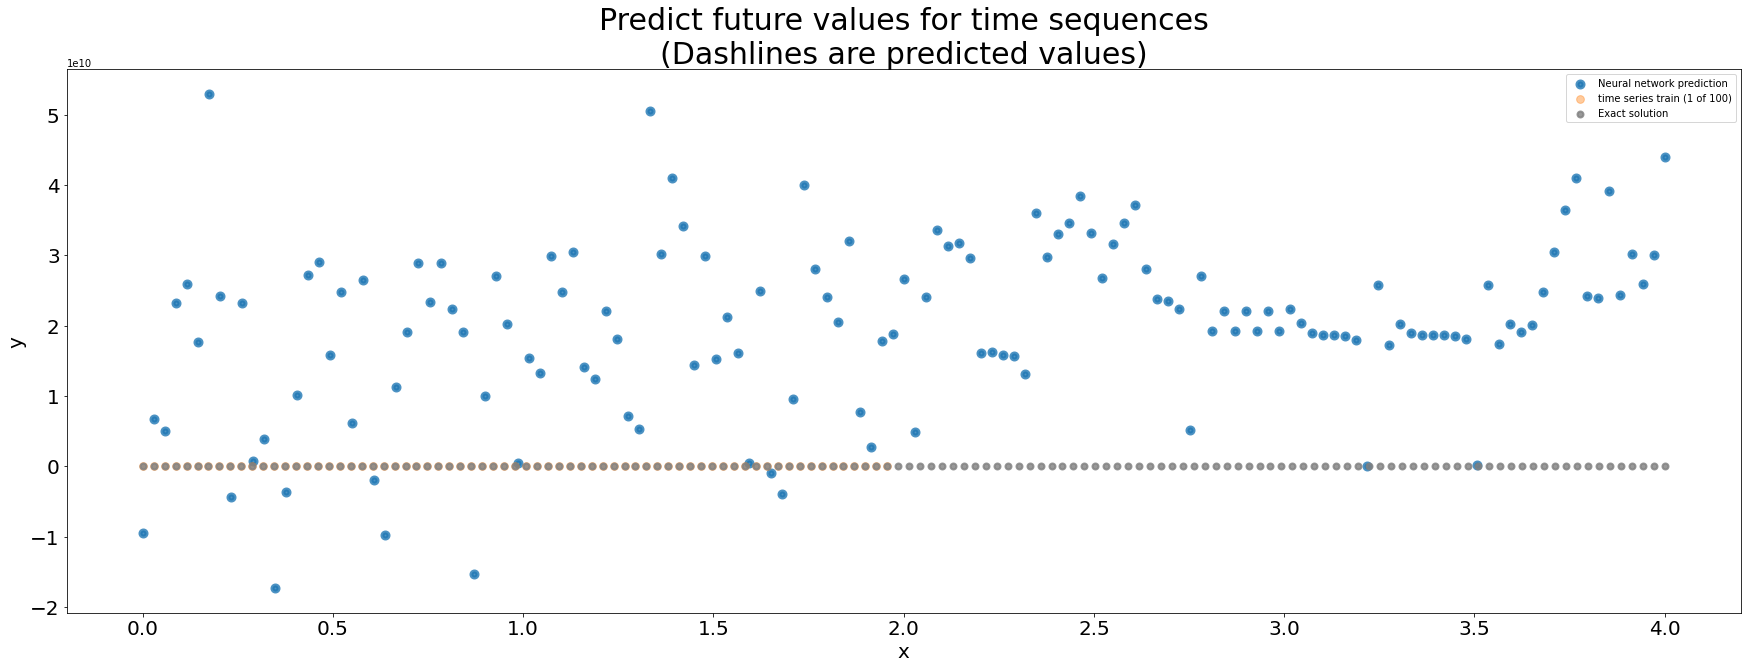

STEP:  12
loss: 2.594955985339254e+20
loss: 2.1140695336123525e+20
loss: 1.6996519902607888e+20
loss: 1.5294011469099067e+20
loss: 4.356615505594517e+20
loss: 2.613587764025779e+21
loss: 1.672155157182762e+21
loss: 5.740214338602536e+21
loss: 4.248663800313981e+21
loss: 2.9552015583605267e+21
loss: 3.4801996777219875e+21
loss: 6.614767505816682e+20
loss: 5.453553044708498e+20
loss: 2.2070763672256826e+22
loss: 7.772873075807098e+20
loss: 9.288199242428449e+19
loss: 7.3052133091576906e+19
loss: 5.1455173855079825e+20
loss: 5.984996800299144e+21
loss: 1.2022119951535335e+21
Loss u: 1.950670e+20


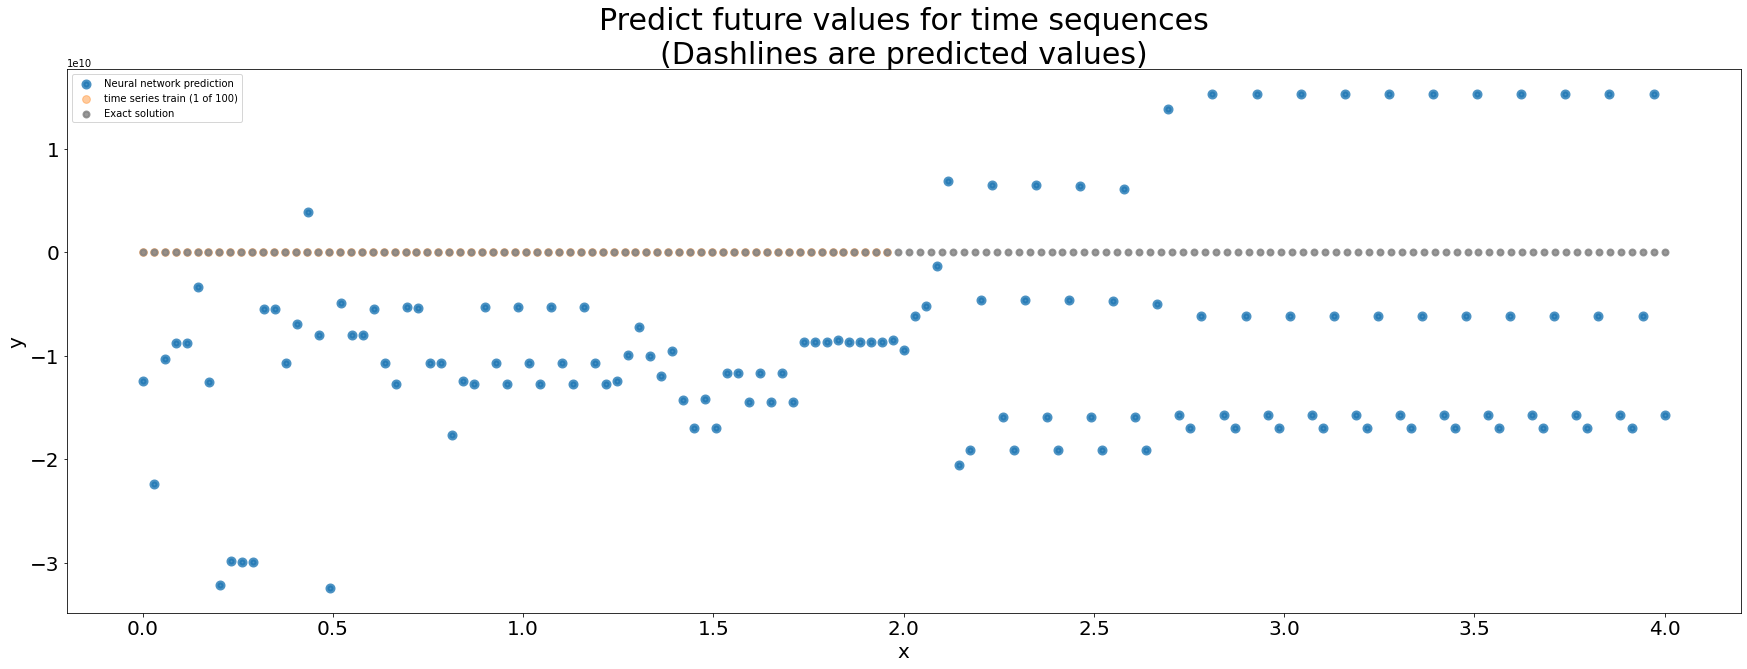

STEP:  13
loss: 2.8600148136425633e+20
loss: 2.9204717683590824e+20
loss: 4.355628583957425e+20
loss: 6.019520409880148e+20
loss: 1.5698066335261167e+21
loss: 2.434316808755599e+20
loss: 5.771954723613825e+20
loss: 1.9758941712325332e+20
loss: 9.882045472590266e+19
loss: 4.941731261588072e+20
loss: 7.139472750464876e+20
loss: 1.5679747943776838e+21
loss: 2.521946961899579e+19
loss: 3.1126883911268827e+19
loss: 2.090899920904415e+19
loss: 3.3150673160851004e+20
loss: 3.097626401240305e+19
loss: 2.0077682656538526e+19
loss: 6.384915919444063e+19
loss: 2.9031538005146337e+19
Loss u: 2.172336e+19


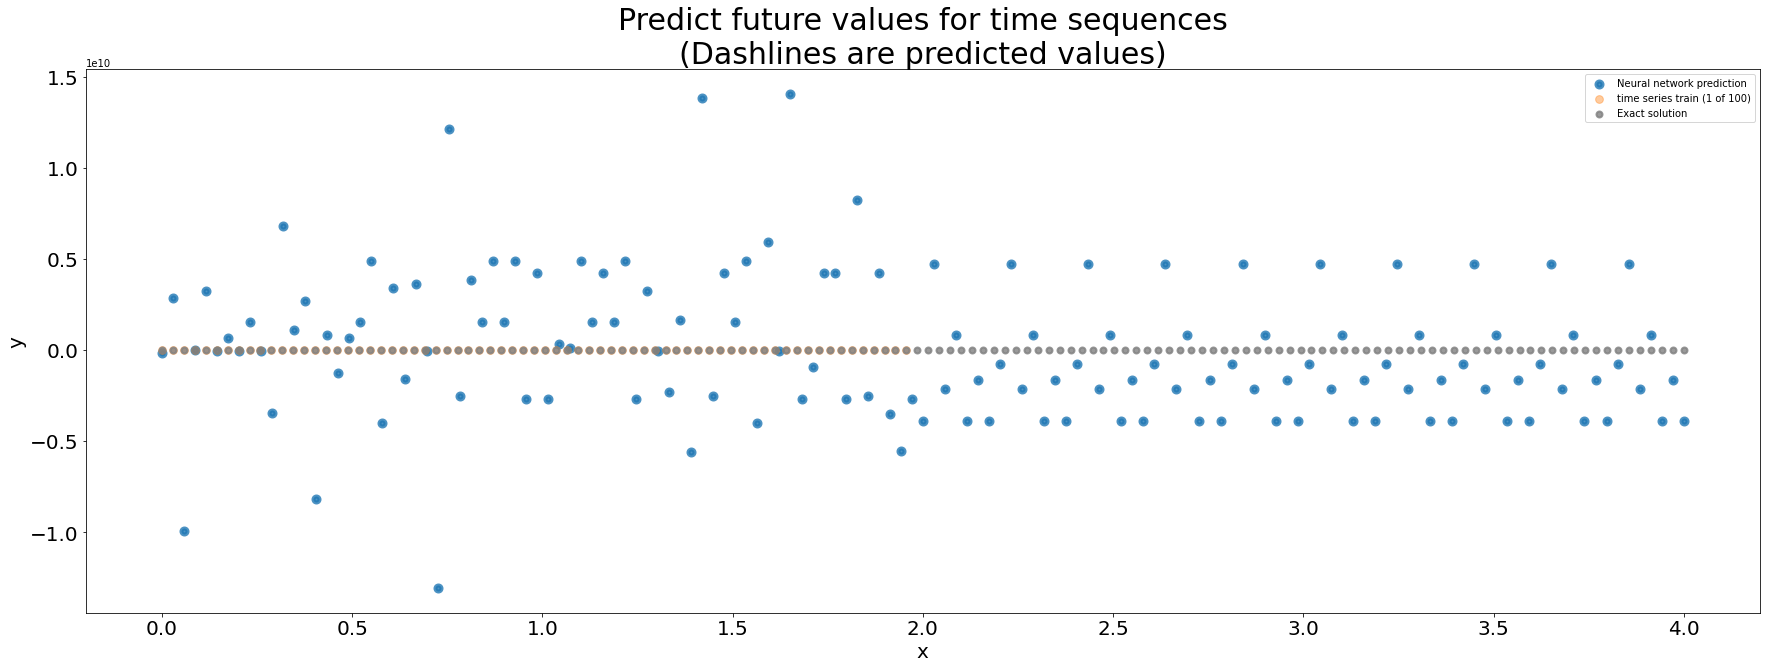

STEP:  14
loss: 5.9005150767110685e+19
loss: 1.8848859665243046e+19
loss: 1.3833800213979988e+20
loss: 3.331828315319383e+19
loss: 5.444185205639846e+19
loss: 8.381331727541128e+19
loss: 3.220719806602386e+19
loss: 1.3834889170296137e+20
loss: 8.447443254175411e+22
loss: 1.3766932314825163e+20
loss: 7.579566617113846e+20
loss: 1.1388791578234035e+20
loss: 8.75063129503202e+19
loss: 4.4599889500101096e+20
loss: 5.179936708610115e+21
loss: 2.8227130460414253e+20
loss: 3.14959380677644e+20
loss: 6.823719751090396e+20
loss: 3.173026880062579e+21
loss: 4.52817391865689e+25
Loss u: 3.135643e+21


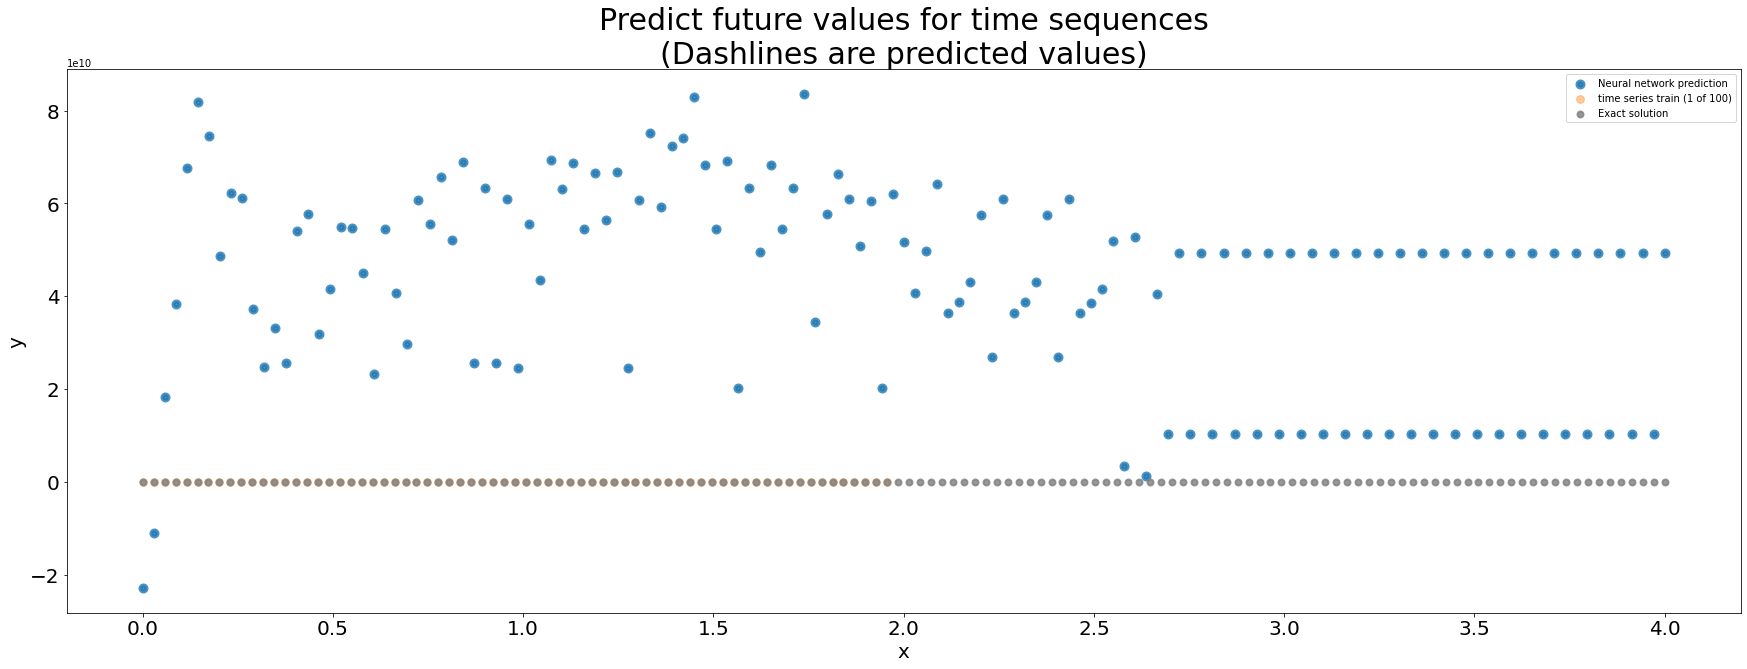

STEP:  15
loss: 3.9595372078364224e+21
loss: 2.5784135250361083e+21
loss: 1.7495889232758634e+21
loss: 3.1927692534540875e+20
loss: 1.1774914553239201e+21
loss: 7.731203379517364e+21
loss: 1.2615456008301865e+20
loss: 4.390557165661171e+20
loss: 3.0909115517880815e+20
loss: 2.6200651365585886e+20
loss: 2.4292126118966723e+20
loss: 5.268655299100756e+20
loss: 4.2262468516937676e+20
loss: 3.0984413592588124e+20
loss: 1.2292937722677772e+22
loss: 9.102794490018907e+20
loss: 2.0541912914479504e+21
loss: 1.1399766111654123e+21
loss: 6.634854404579685e+21
loss: 2.0951927661429732e+21
Loss u: 5.801396e+20


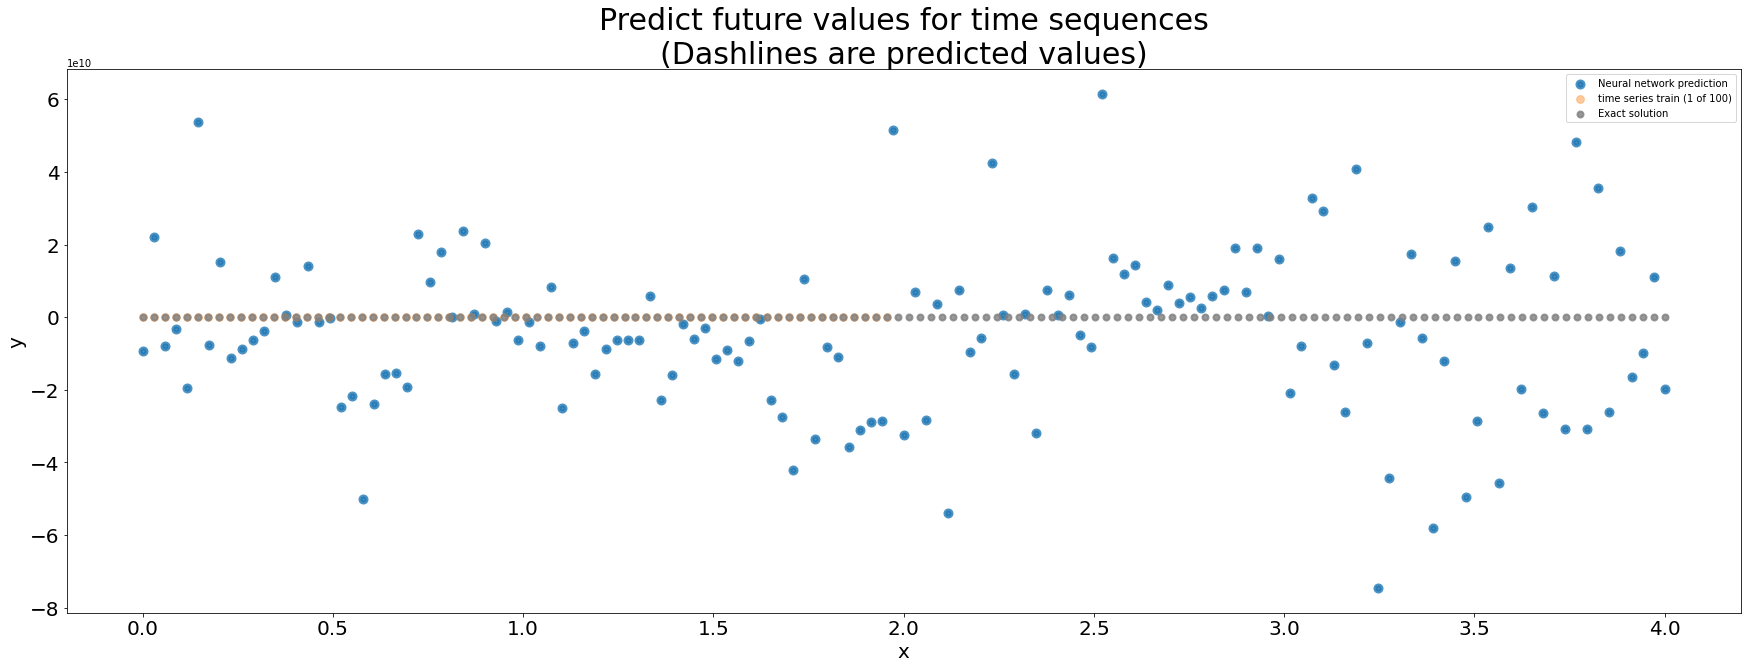

STEP:  16
loss: 1.527416924245957e+21
loss: 1.1786787167756857e+21
loss: 7.717801792926216e+20
loss: 1.1686135938209777e+21
loss: 2.63293030221287e+20
loss: 1.3023554438426274e+21
loss: 5.504073088434791e+25
loss: 4.7035034373053806e+21
loss: 9.932502500993558e+20
loss: 2.995929580115675e+21
loss: 4.2542606487508956e+20
loss: 5.8598977098061395e+20
loss: 2.6794903095636027e+20
loss: 2.7937867422941735e+20
loss: 5.118289607323319e+20
loss: 3.986771987711132e+19
loss: 2.6175519168602833e+20
loss: 4.512645529434535e+20
loss: 1.6672084807576768e+20
loss: 2.388204557724069e+21
Loss u: 6.994721e+20


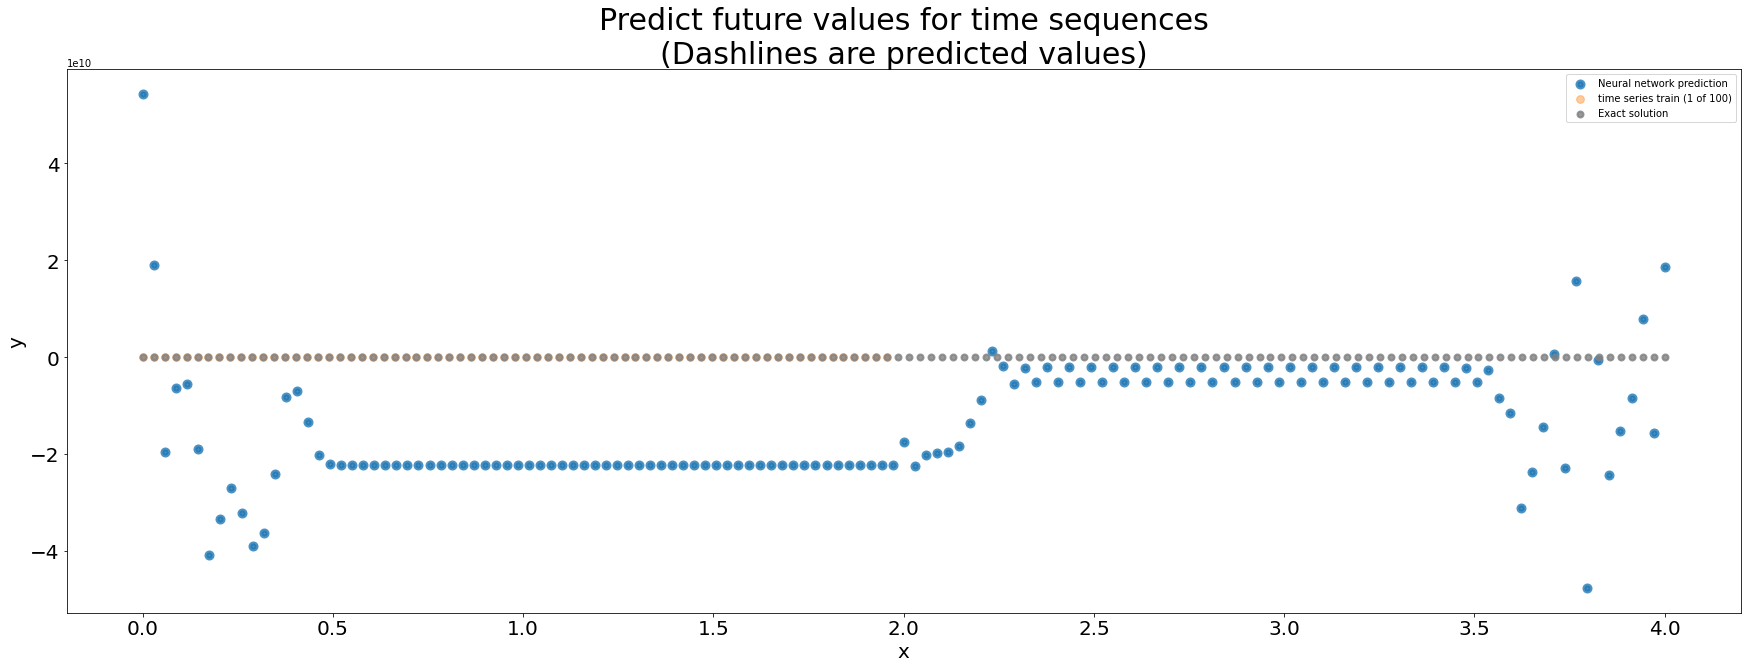

Wall time: 55.4 s


In [9]:


%%time 

x_plot = np.linspace(0,4,2*n_mitad).astype(np.float32)
y_exact = oscillator_numpy(d, w0, x_plot).astype(np.float32)
input_graph = (y_exact + noise*np.std(y_exact)*np.random.randn(x_plot.size))[:len(inpu[0])]

# build the model
seq = PhysicsInformedNN()

files = []


#begin to train

for i in range(17):
    print('STEP: ', i)

    def closure():
        seq.dnn.optimizer.zero_grad()
    
        physics , u_pred , u_t , u_tt = seq.net_f(inpu)
        
        #c_i = u_pred[:,0]
        #ones= torch.ones_like(c_i)
        #loss_u_pred = torch.mean((ones - c_i)**2)
        #loss_u_t = torch.mean((u_t[:,0])**2)
        #
        loss_u = torch.mean((target - u_pred)**2)
        # compute the "physics loss"
        #loss_pde = (1e-8)*torch.mean(physics**2)
        loss = loss_u #+ loss_pde + (1e-4)*(loss_u_pred + loss_u_t)
        print('loss:', loss.item())
        loss.backward(retain_graph=True)
        return loss
    
    seq.dnn.optimizer.step(closure)
    
    with torch.no_grad():
        future = n_mitad
        pred = seq.net_u(test_input, future_preds=future)
        loss_u = torch.mean((test_target - pred[:, :-future])**2)
        print('Loss u: %e'%(loss_u.item()))
        y = pred.detach().cpu().numpy()
    
    # draw the result
    plt.figure(figsize=(30,10))
    plt.title('Predict future values for time sequences\n(Dashlines are predicted values)', fontsize=30)
    plt.xlabel('x', fontsize=20)
    plt.ylabel('y', fontsize=20)
    plt.xticks(fontsize=20)
    plt.yticks(fontsize=20)
    d_t=len(y[0])
    eje_x= np.linspace(0,4,d_t)
    plt.scatter(eje_x, y[0], color="tab:blue", linewidth=4, alpha=0.8, label="Neural network prediction")
    plt.scatter(x_plot[:len(inpu[0])], inpu[0].detach().cpu().numpy(), s=60, color="tab:orange", alpha=0.4, label='time series train (1 of 100)')
    plt.scatter(x_plot, y_exact, color="grey", linewidth=2, alpha=0.8, label="Exact solution")
    plt.legend()

    file = 'plots_normal_lstm_noise/predict%d.jpg'%i
    plt.savefig(file, bbox_inches='tight', pad_inches=0.1, dpi=100, facecolor="white")
    files.append(file)
    plt.show()
    plt.close()
    
    # begin to predict, no need to track gradient here


In [10]:
from PIL import Image

outfile="plots_normal_lstm_noise_gif/lstm_noise.gif"


In [11]:
imgs = [Image.open(file) for file in files]
imgs[0].save(fp=outfile, format='GIF', append_images=imgs[1:], save_all=True, duration=int(1000/10), loop=0) 

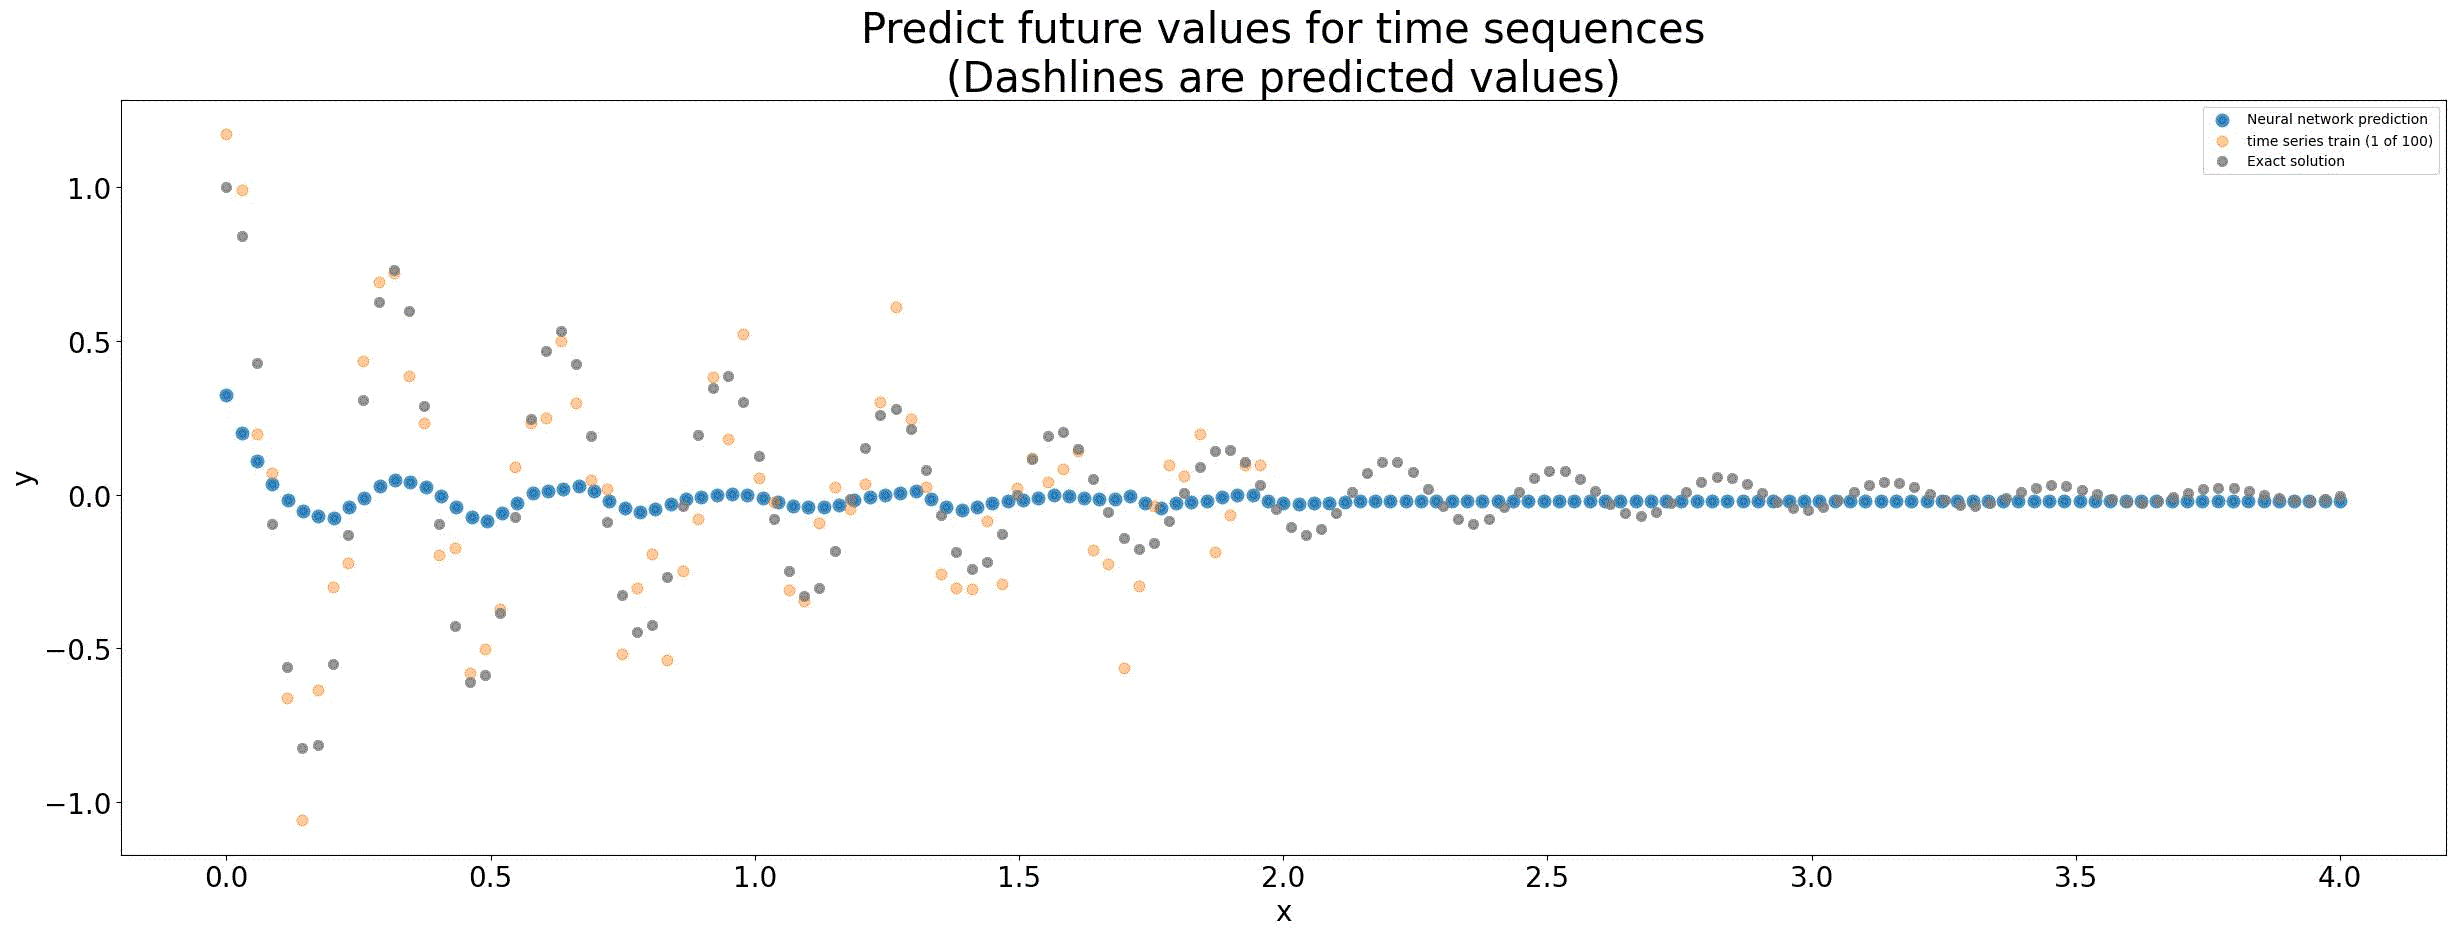

In [12]:
from IPython.display import Image

Image(outfile)

In [13]:
writer 

NameError: name 'writer' is not defined